In [4]:
# Import modules
import os
import re
from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import platform
from datetime import timedelta
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [10]:
# Environment/Package version logging for reproducibility.
# This cell logs the current environment and Python package versions for transparency and reproducibility.
print(f"Python Version: {platform.python_version()}")
print(f"Numpy version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"Matplotlib Version: {matplotlib.__version__}")
print(f"seaborn Version: {sns.__version__}")

Python Version: 3.12.4
Numpy version: 1.26.4
Pandas Version: 2.2.2
Matplotlib Version: 3.8.4
seaborn Version: 0.13.2


In [12]:
# Get the base directory (current working directory)
base_dir = os.getcwd()

In [14]:
# Set relative paths
heat_wave_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "heat_wave_library", "With_spatial_coverage"))
cold_snap_path = os.path.abspath(os.path.join(base_dir, "..", "..", "data", "cold_snap_library", "With_spatial_coverage"))

# Over view of the workflow
This script read in heat wave/cold snap event library and then visualize the evenrs in year 1980 under definition 4

In [ ]:
# Read in heat wave and cold snap libraries
hw_library = pd.read_csv(heat_wave_path)
cs_library = pd.read_csv(cold_snap_path)

In [22]:
# Convert Kelvin to degree C
hw_library['highest_temp_c'] = hw_library['highest_temp'] - 273.15
cs_library['lowest_temp_c'] = cs_library['lowest_temp'] - 273.15

In [23]:
# Ensure 'start_date' and 'end_date' are datetime objects
hw_library['start_date'] = pd.to_datetime(hw_library['start_date'])
hw_library['end_date'] = pd.to_datetime(hw_library['end_date'])
cs_library['start_date'] = pd.to_datetime(cs_library['start_date'])
cs_library['end_date'] = pd.to_datetime(cs_library['end_date'])


In [24]:
# Create 'year' column based on 'start_date'
hw_library['year'] = hw_library['start_date'].dt.year
cs_library['year'] = cs_library['start_date'].dt.year

In [29]:
# Filter for events in 1980
hw_events = hw_library[hw_library['year'] == 1980]
cs_events = cs_library[cs_library['year'] == 1980]

In [33]:
# List of all NERC regions
all_nerc_regions = ['NERC4', 'NERC10', 'NERC9', 'NERC20', 'NERC11', 'NERC12', 'NERC17', 'NERC15', 'NERC5', 'NERC18', 
                    'NERC8', 'NERC3', 'NERC1', 'NERC7', 'NERC6', 'NERC2']

# Initialize a DataFrame for the entire year for each NERC region
events_data_1980 = pd.DataFrame(0.0, index=all_nerc_regions, columns=range(1, 366))
date_range = pd.date_range(start='1980-01-01', end='1980-12-31')

# Populate the DataFrame with heat wave data
for _, row in hw_events.iterrows():
    start_day = row['start_date'].timetuple().tm_yday
    end_day = row['end_date'].timetuple().tm_yday
    events_data_1980.loc[row['NERC_ID'], start_day:end_day] = row['highest_temp_c']

# Populate the DataFrame with cold snap data
for _, row in cs_events.iterrows():
    start_day = row['start_date'].timetuple().tm_yday
    end_day = row['end_date'].timetuple().tm_yday
    events_data_1980.loc[row['NERC_ID'], start_day:end_day] = row['lowest_temp_c']

In [35]:
# Define the function to extract numbers
def extract_number(s):
    return re.findall(r'\d+', s)[0]

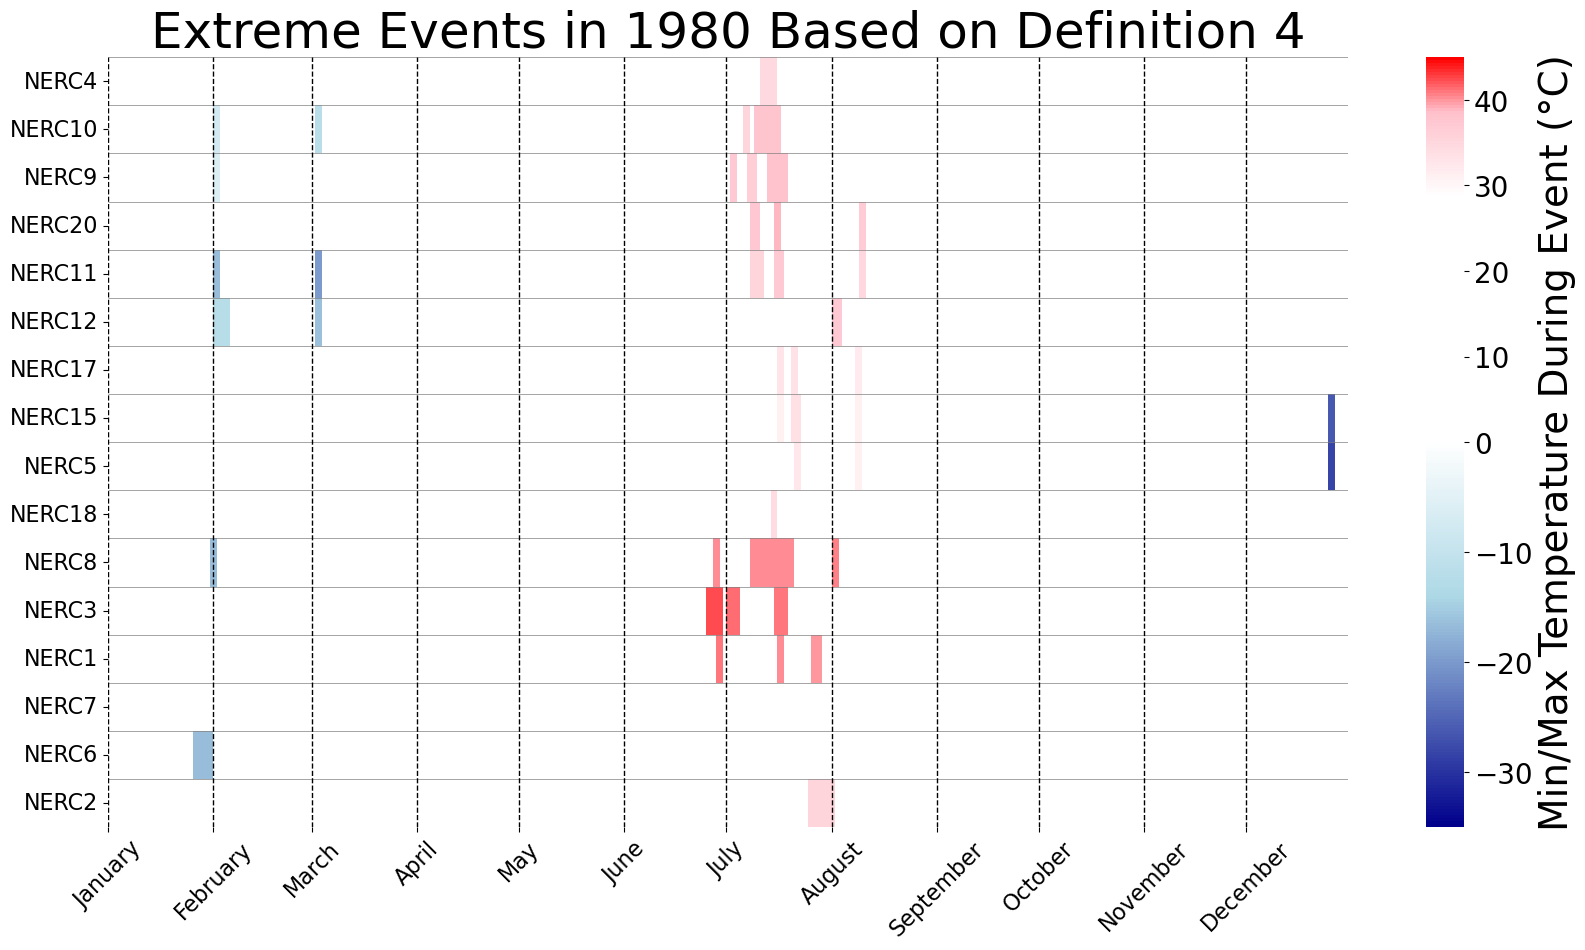

In [39]:
# %matplotlib qt
# Custom color map with gradients
colors = [(0, "darkblue"),  
          (0.3, "lightblue"),  
          (0.5, "white"),   
          (0.82, "white"), 
          (0.93, "pink"), 
          (1, "red")]  

cmap = LinearSegmentedColormap.from_list("custom_cold_hot", colors)

# Define the normalization
norm = TwoSlopeNorm(vmin=-35, vcenter=0, vmax=45)

# Create the heatmap
plt.figure(figsize=(20, 10))
ax = sns.heatmap(events_data_1980, cmap=cmap, norm=norm, cbar_kws={'label': 'Event intensity (°C)'})
plt.yticks(fontsize=16)

# Calculate the start of each month positions for the x-ticks
month_starts = pd.date_range('1980-01-01', periods=12, freq='MS')
month_labels = month_starts.strftime('%B')

# Convert month starts to indices by finding the day of the year for each month start
month_indices = [(date - pd.Timestamp('1980-01-01')).days for date in month_starts]
# Set month labels on the x-axis
plt.xticks(month_indices, [month.strftime('%B') for month in month_starts], rotation=45, fontsize=16)

# Adding horizontal grid lines
for i in range(events_data_1980.shape[0]):
    ax.hlines(i, *ax.get_xlim(), colors='gray', linestyles='solid', linewidth=0.5)

# Adding vertical grid lines at each month start
for pos in month_indices:
    ax.vlines(pos, *ax.get_ylim(), colors='black', linestyles='dashed', linewidth=1)

# Adding grid lines
ax.grid(True, which='minor', axis='both', linestyle='--', color='gray', linewidth=0.5)


# Customize the colorbar
cbar = ax.collections[0].colorbar
cbar.set_label('Min/Max Temperature During Event (°C)', fontsize=28)
cbar.ax.tick_params(labelsize=20)

# Add a title
plt.title('Extreme Events in 1980 Based on Definition 4', fontsize=36)

plt.show()